In [1]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 87% 130M/149M [00:00<00:00, 190MB/s]
100% 149M/149M [00:00<00:00, 187MB/s]


In [2]:
!unzip /content/brain-tumor-mri-dataset.zip -d /content

Streaming output truncated to the last 5000 lines.
  inflating: /content/Training/glioma/Tr-gl_0712.jpg  
  inflating: /content/Training/glioma/Tr-gl_0713.jpg  
  inflating: /content/Training/glioma/Tr-gl_0714.jpg  
  inflating: /content/Training/glioma/Tr-gl_0715.jpg  
  inflating: /content/Training/glioma/Tr-gl_0716.jpg  
  inflating: /content/Training/glioma/Tr-gl_0717.jpg  
  inflating: /content/Training/glioma/Tr-gl_0718.jpg  
  inflating: /content/Training/glioma/Tr-gl_0719.jpg  
  inflating: /content/Training/glioma/Tr-gl_0720.jpg  
  inflating: /content/Training/glioma/Tr-gl_0721.jpg  
  inflating: /content/Training/glioma/Tr-gl_0722.jpg  
  inflating: /content/Training/glioma/Tr-gl_0723.jpg  
  inflating: /content/Training/glioma/Tr-gl_0724.jpg  
  inflating: /content/Training/glioma/Tr-gl_0725.jpg  
  inflating: /content/Training/glioma/Tr-gl_0726.jpg  
  inflating: /content/Training/glioma/Tr-gl_0727.jpg  
  inflating: /content/Training/glioma/Tr-gl_0728.jpg  
  inflating: /

In [3]:
import random, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import seaborn as sns
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Flatten, Activation, Dropout,  Conv2D, MaxPooling2D,ZeroPadding2D
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.initializers import glorot_uniform
from keras.utils import plot_model
from PIL import Image, ImageDraw
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.preprocessing import image

In [5]:
train_datagen = ImageDataGenerator(  rescale=1./255, shear_range=0.2,  zoom_range=0.2,
                   horizontal_flip=True, validation_split=0.2)
val_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

train = train_datagen.flow_from_directory('/content/Training',target_size=(256, 256),
        batch_size=32, class_mode='categorical', subset='training')

val = train_datagen.flow_from_directory('/content/Training',
        target_size=(256, 256), batch_size=32, class_mode='categorical', subset='validation')

test = test_datagen.flow_from_directory('/content/Testing',
        target_size=(256, 256),batch_size=32,  class_mode='categorical')


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [6]:
print(train.class_indices)
print(test.class_indices)
print(val.class_indices)

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


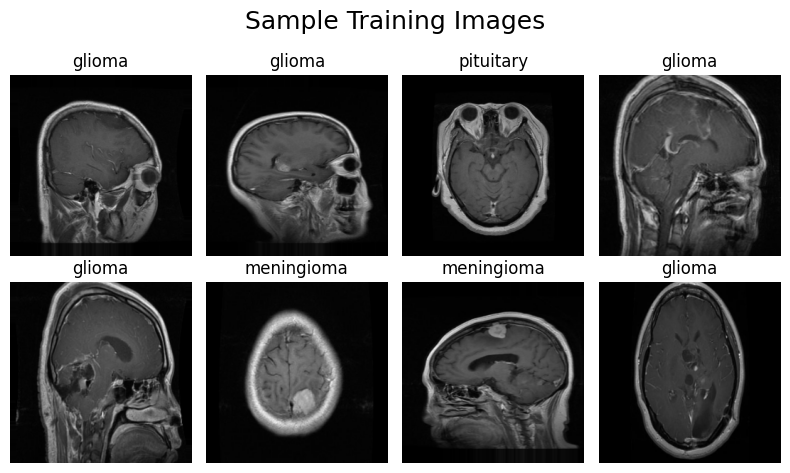

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(8,5))
idx = 0
labels = {value: key for key, value in train.class_indices.items()}
for i in range(2):
    for j in range(4):
        lable = labels[np.argmax(train[0][1][idx])]
        ax[i,j].set_title(f"{lable}")
        ax[i, j].imshow(train[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=18)
plt.tight_layout()
plt.show()

In [ ]:
IMG_SIZE = (224,224)
import imutils
img = cv2.imread('/content/Training/meningioma/Tr-meTr_0001.jpg')
img = cv2.resize(img,   dsize=IMG_SIZE,  interpolation=cv2.INTER_CUBIC  )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

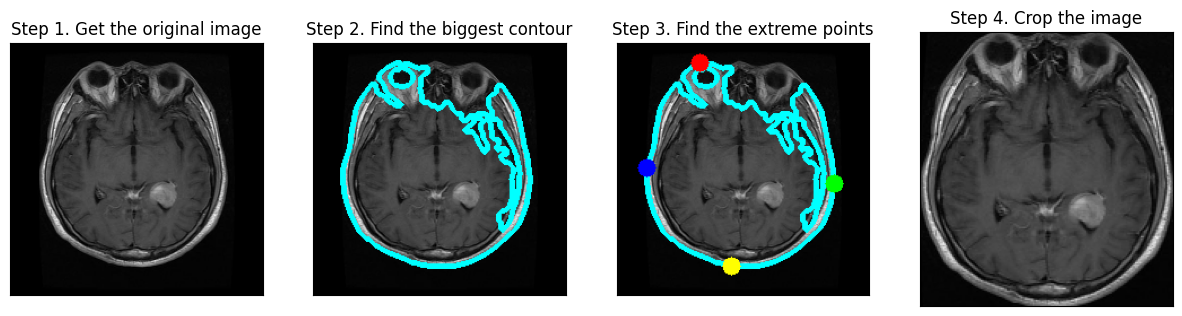

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

### VGG19

In [39]:
from keras.applications import VGG19
base = VGG19(include_top=False,classifier_activation="softmax",input_shape=(256,256,3))
for layer in base.layers:
    layer.trainable = False

In [40]:
vgg = Sequential([base, Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

In [41]:
vgg.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [42]:
vgg.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_5 (Dense)             (None, 256)               8388864   
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 28414276 (108.39 MB)
Trainable params: 8389892 (32.00 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [44]:
es = EarlyStopping(monitor='val_loss', patience = 7, min_delta=0.01, verbose=1,
                   restore_best_weights=True)

In [45]:
for layer in vgg.layers:
  print(layer.name, layer.input_shape, layer.output_shape)

vgg19 (None, 256, 256, 3) (None, 8, 8, 512)
flatten_2 (None, 8, 8, 512) (None, 32768)
dense_5 (None, 32768) (None, 256)
dropout_4 (None, 256) (None, 256)
dense_6 (None, 256) (None, 4)


In [46]:
vgg_his = vgg.fit(train, epochs=20,validation_data=val,callbacks=[es]).history

Epoch 1/20
143/143 [==============================] - 123s 801ms/step - loss: 1.2262 - accuracy: 0.6716 - val_loss: 0.8384 - val_accuracy: 0.6924
Epoch 2/20
143/143 [==============================] - 111s 775ms/step - loss: 0.4980 - accuracy: 0.8049 - val_loss: 0.6192 - val_accuracy: 0.7721
Epoch 3/20
143/143 [==============================] - 122s 857ms/step - loss: 0.4336 - accuracy: 0.8370 - val_loss: 0.6361 - val_accuracy: 0.7721
Epoch 4/20
143/143 [==============================] - 101s 705ms/step - loss: 0.4100 - accuracy: 0.8416 - val_loss: 0.5643 - val_accuracy: 0.7800
Epoch 5/20
143/143 [==============================] - 103s 720ms/step - loss: 0.3689 - accuracy: 0.8589 - val_loss: 0.5972 - val_accuracy: 0.7905
Epoch 6/20
143/143 [==============================] - 101s 705ms/step - loss: 0.3490 - accuracy: 0.8650 - val_loss: 0.6788 - val_accuracy: 0.7870
Epoch 7/20
143/143 [==============================] - 101s 708ms/step - loss: 0.3271 - accuracy: 0.8670 - val_loss: 0.5848 -

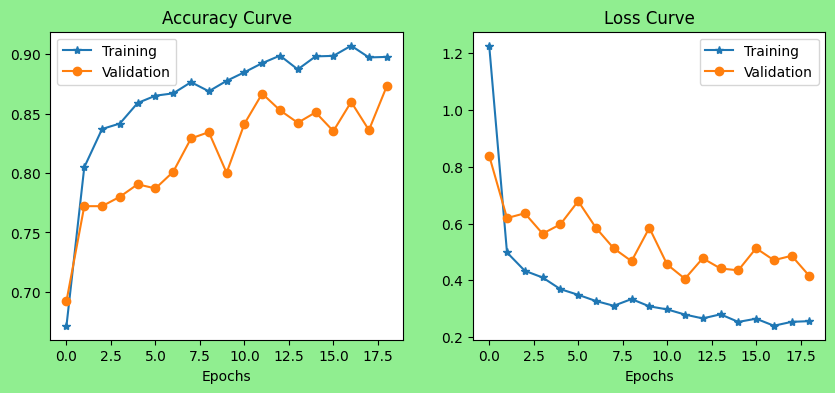

In [50]:
plt.figure(figsize = (10,4),facecolor='lightgreen')

acc = vgg_his['accuracy']
val_acc = vgg_his['val_accuracy']
loss = vgg_his['loss']
val_loss = vgg_his['val_loss']

plt.subplot(1,2,1)
plt.title('Accuracy Curve')
plt.plot(acc,'*-',label="Training")
plt.plot(val_acc,'o-',label="Validation")
plt.xlabel('Epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.title('Loss Curve')
plt.plot(loss,'*-',label="Training")
plt.plot(val_loss,'o-',label="Validation")
plt.xlabel('Epochs')
plt.legend(loc='best')

plt.show()

### Traditional CNN

In [9]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size= (3,3), activation= 'relu', input_shape=(256,256,3)) )

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu' ))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu' ))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu' ))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=4, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 126, 126, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 126, 126, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                   

In [10]:
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [11]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', patience=7, min_delta=0.01,verbose=1,restore_best_weights=True)

In [ ]:
plot_model(model,show_shapes=True, show_layer_names=True, show_layer_activations=True)

### Training

In [14]:
tr_steps = train.samples//train.batch_size +1
val_steps = val.samples//val.batch_size +1
tr_steps, val_steps

(143, 36)

In [15]:
his = model.fit(train,validation_data=val,steps_per_epoch=140,validation_steps=35,epochs=20,
                callbacks=[es]).history

Epoch 1/20
140/140 [==============================] - 114s 737ms/step - loss: 1.1160 - accuracy: 0.5381 - val_loss: 1.0754 - val_accuracy: 0.6339
Epoch 2/20
140/140 [==============================] - 99s 710ms/step - loss: 0.6059 - accuracy: 0.7620 - val_loss: 0.8505 - val_accuracy: 0.6982
Epoch 3/20
140/140 [==============================] - 163s 1s/step - loss: 0.4767 - accuracy: 0.8192 - val_loss: 0.7091 - val_accuracy: 0.7357
Epoch 4/20
140/140 [==============================] - 138s 987ms/step - loss: 0.3893 - accuracy: 0.8539 - val_loss: 0.6806 - val_accuracy: 0.7518
Epoch 5/20
140/140 [==============================] - 111s 786ms/step - loss: 0.3271 - accuracy: 0.8791 - val_loss: 0.8451 - val_accuracy: 0.7330
Epoch 6/20
140/140 [==============================] - 121s 863ms/step - loss: 0.2786 - accuracy: 0.8994 - val_loss: 0.6450 - val_accuracy: 0.8018
Epoch 7/20
140/140 [==============================] - 99s 703ms/step - loss: 0.2797 - accuracy: 0.8983 - val_loss: 0.6461 - val_

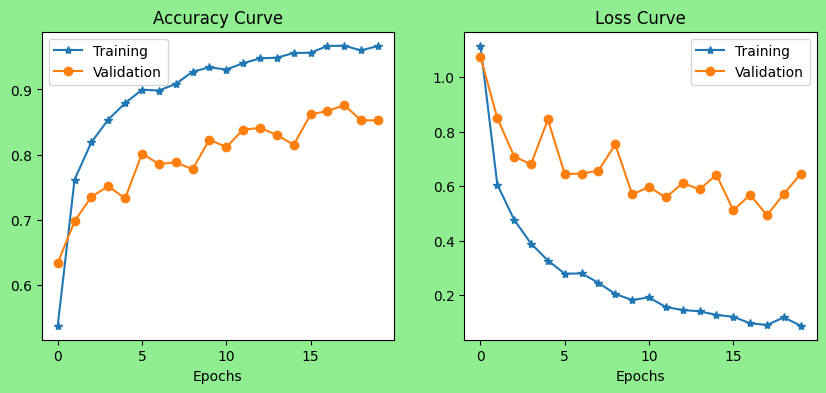

In [47]:
plt.figure(figsize = (10,4),facecolor='lightgreen')

acc = his['accuracy']
val_acc = his['val_accuracy']
loss = his['loss']
val_loss = his['val_loss']

import matplotlib.pyplot as plt

plt.subplot(1,2,1)
plt.title('Accuracy Curve')
plt.plot(acc,'*-',label="Training")
plt.plot(val_acc,'o-',label="Validation")
plt.xlabel('Epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.title('Loss Curve')
plt.plot(loss,'*-',label="Training")
plt.plot(val_loss,'o-',label="Validation")
plt.xlabel('Epochs')
plt.legend(loc='best')

plt.show()

### Testing and Evaluation

In [52]:
result = vgg.evaluate(test)

41/41 [==============================] - 16s 395ms/step - loss: 0.3450 - accuracy: 0.8726


In [53]:
print("Test Loss: {:0.3f}%".format(result[0]*100))
print("Test Accuracy: {:0.3f}%".format(result[1]*100))

Test Loss: 34.496%
Test Accuracy: 87.262%


In [54]:
true_classes = test.classes
predicted_classes = np.argmax(model.predict(test,steps=np.ceil(test.samples/test.batch_size)), axis=1)

41/41 [==============================] - 3s 78ms/step


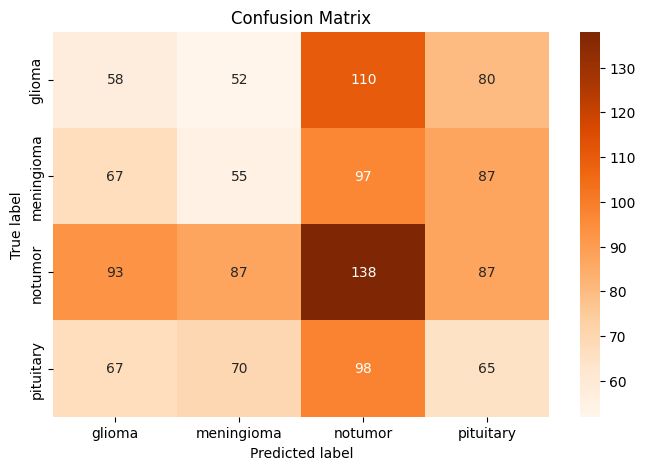

In [55]:
from sklearn.metrics import confusion_matrix, classification_report
class_labels = list(test.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [56]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

      glioma       0.20      0.19      0.20       300
  meningioma       0.21      0.18      0.19       306
     notumor       0.31      0.34      0.33       405
   pituitary       0.20      0.22      0.21       300

    accuracy                           0.24      1311
   macro avg       0.23      0.23      0.23      1311
weighted avg       0.24      0.24      0.24      1311



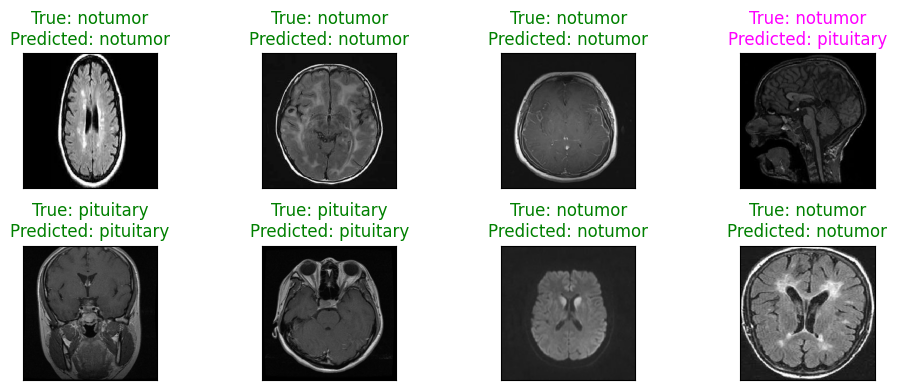

In [59]:
# Assuming test_generator and model are already defined
batch_size = test.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 4),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0),axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if class_labels[Random_Img_Label] == class_labels[Model_Prediction] else "magenta"
    ax.set_title(f"True: {class_labels[Random_Img_Label]}\nPredicted: {class_labels[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()